###  Notebook Overview: Evaluation of Five Machine Learning Models for Iron Deficiency Detection

- This notebook performs a complete workflow for evaluating five machine learning models for iron deficiency detection using hematological features.

- Due to internal data governance policies, we are unable to share the original patient-level datasets. However, we have preserved the model output results in the `data/cache/` directory, including fold-wise predicted probabilities and true labels. These files are sufficient for reproducing the **DeLong's test**, **calibration plot**, and computation of **Brier Score** and **ECCE-R**.

---


####  Workflow Steps:

##### ❌ Non-executable Steps:
- **Loading and preprocessing original datasets** for training, testing, and external validation (in An-Nan Hospital, and Wei-Gong Memorial hospitals).
- **Cross validation with five Models** - RF, LGB, XGB, CatBoost, LR.

- **Cross validation with single model**  - RF. 


##### ▶️ Executable Steps (using saved outputs):

- **Perform DeLong statistical tests**:
   - Load saved model predictions from the `data/cache/` directory for ROC-AUC evaluation.
   - Comparing **different models** under the same variable combination.
   - Comparing **different variable combinations** using the same model.
   - Comparing **different impute methods** using the same model.
- **Compute Brier Score and ECCE-R** for calibration assessment.

####  External Dependencies:
- DeLong test implementation adapted from [yandexdataschool/roc_comparison](https://github.com/yandexdataschool/roc_comparison)

---


### **Import Library**

In [ ]:
import os
import sys

# ============================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from itertools import combinations
from joblib import dump, load
from xgboost import XGBClassifier
from sklearn.calibration import calibration_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import StratifiedKFold
from scipy.stats import sem
from tqdm.auto import tqdm

# ============================

sys.path.append('../src') 
from config import data_dir, cache_dir, feature_selection_dir
from model_utils import (
    get_chosen_columns,
    performance,
    evaluate_model,
    imputer,
    scaling,
    compute_ecce_r,
    print_model_summary,
    print_baseline_performance,
)

# DeLong test implementation used below is adapted from:
# https://github.com/yandexdataschool/roc_comparison
from compare_auc_delong_xu import delong_roc_test

### **Setting**

- Parameter

In [8]:
random_seed= 190   
threshold= 0.5   # for binary threshold for positive prediction
K=5              # for k-fold cross validation

female_ferritin_threshold= 11
male_ferritin_threshold= 23.9
TIBC_threshold= 450

weight_for_0 = 1 # for iron deficiency negative samples
weight_for_1 = 8 # for iron deficiency positive samples
    
impute_method= 'zero' # {'mean', 'median', 'zero', 'knn', 'mice'}

- Models

In [ ]:
machine_models = []

machine_models.append (('XGB', XGBClassifier(random_state=random_seed)))
machine_models.append(('Catboost',  CatBoostClassifier(verbose=False, random_state=random_seed, logging_level='Silent')))
machine_models.append (('LGB', LGBMClassifier(verbosity=-1, random_state=random_seed)))
machine_models.append (('RF',  RandomForestClassifier(random_state=random_seed)))
machine_models.append(('LR', LogisticRegression(solver='lbfgs', max_iter=500)))

### **Loading data**

In [ ]:
# Load training and test data (internal validation) 
data_train = pd.read_csv(
    os.path.join(data_dir, 'CMUH_train_set.csv'),
    index_col=0
)

data_test = pd.read_csv(
    os.path.join(data_dir, 'CMUH_valid_set.csv'),
    index_col=0
)

# Load external validation datasets from ANH and WMH hospitals
data_ANH = pd.read_csv(
    os.path.join(data_dir, 'ANH.csv'),
    index_col=0
)

data_WMH = pd.read_csv(
    os.path.join(data_dir, 'WMH.csv'),
    index_col=0
)

In [ ]:
# Recalculate and summarize the proportion and counts of positive cases in each dataset
positive_ratios_counts = {
    'data_train': (data_train['Label'].mean() * 100, data_train['Label'].sum(), len(data_train) - data_train['Label'].sum()),
    'data_test': (data_test['Label'].mean() * 100, data_test['Label'].sum(), len(data_test) - data_test['Label'].sum()),
    'data_ANH': (data_ANH['Label'].mean() * 100, data_ANH['Label'].sum(), len(data_ANH) - data_ANH['Label'].sum()),
    'data_WMH': (data_WMH['Label'].mean() * 100, data_WMH['Label'].sum(), len(data_WMH) - data_WMH['Label'].sum()),
}

# Display the results: percentage of positives, and counts of positive/negative cases
for dataset, (percentage, positive, negative) in positive_ratios_counts.items():
    print(f"{dataset}: {percentage:.2f}% ({int(positive)} positive cases, {int(negative)} negative cases)")

data_train: 18.83% (1026 positive cases, 4423 negative cases)
data_test: 15.99% (273 positive cases, 1434 negative cases)
data_AN: 19.27% (264 positive cases, 1106 negative cases)
data_WK: 19.62% (249 positive cases, 1020 negative cases)


### **Define variables**

- Variable combination set

In [9]:
vars_list = [
    ['CBC', 'CPD', 'basic'],
    ['CBC', 'basic'],
    ['CBC', 'CPD'],
    ['CBC'],
    ['CBC(RBC)', 'basic'],
    ['CBC(RBC)'],
    ['CBC(RBC)', 'CPD(RBC)', 'basic'],
    ['CBC(RBC)', 'CPD(RBC)'],
    ['CPD(RBC)'],
    ['basic']
    ]

- Assign y_true

In [ ]:
y = data_train['Label']
y_test= data_test['Label']
y_ANH= data_ANH['Label']
y_WMH= data_WMH['Label']

### **Start training**

In [ ]:
results = {}

y_dict = {
    'y_test': y_test,
    'y_ANH': y_ANH,
    'y_WMH': y_WMH
}

for var in tqdm(vars_list):

    chosen_col = get_chosen_columns(var)

    print("="*40)
    print(f"Feature Set: {var}")
    print(f"Total number of selected features: {len(chosen_col)}")
    print("="*40)

    # assign x
    x = data_train.loc[:, chosen_col]  
    x_test= data_test.loc[:, chosen_col]
    x_ANH= data_ANH.loc[:, chosen_col]
    x_WMH= data_WMH.loc[:, chosen_col]
    
    # [Cross validation]- start tratining
    model_name = []
    metrics_columns = ['AUROC', 'AUPRC', 'accuracy', 'F1_score', 'recall', 'specificity', 'precision', 'NPV']
    outcome_total = pd.DataFrame({col: pd.Series(dtype='float') for col in metrics_columns})
    outcome_test_total = pd.DataFrame({col: pd.Series(dtype='float') for col in metrics_columns})
    outcome_ANH_total = pd.DataFrame({col: pd.Series(dtype='float') for col in metrics_columns})
    outcome_WMH_total = pd.DataFrame({col: pd.Series(dtype='float') for col in metrics_columns})
    

    skf = StratifiedKFold(n_splits=K, random_state=random_seed, shuffle=True)
    fold=0

    # Cross validation  
    for train_index, val_index in skf.split(x, y):
        fold=fold+1

        x_train_cv, x_val = x.iloc[train_index], x.iloc[val_index]
        y_train_cv, y_val = y.iloc[train_index], y.iloc[val_index]
        y_dict[f'y_val_{fold}'] = y_val
        
        # train set
        x_train_imp, m_mean = imputer(x_train_cv, impute_method, train=True)
        x_train_scale, train_scaler = scaling(x_train_imp, None, train=True)
        
        # valid set
        x_val_imp = imputer(x_val, impute_method, False, m_mean)
        x_val_scale, train_scaler = scaling(x_val_imp, train_scaler, train=False)
        
        # test set
        x_test_imp = imputer(x_test, impute_method, False, m_mean)
        x_test_scale, train_scaler = scaling(x_test_imp, train_scaler, train=False)
        
        # ANH set
        x_ANH_imp = imputer(x_ANH, impute_method, False, m_mean)
        x_ANH_scale, train_scaler = scaling(x_ANH_imp, train_scaler, train=False)
        
        # WMH set
        x_WMH_imp = imputer(x_WMH, impute_method, False, m_mean)
        x_WMH_scale, train_scaler = scaling(x_WMH_imp, train_scaler, train=False)

        # Sample weight adjustment
        weights_train = np.array([weight_for_0 if label == 0 else weight_for_1 for label in y_train_cv])
       

        # Start training 
        for name, model  in machine_models:

            # model fit
            model.fit (x_train_scale, y_train_cv, sample_weight=weights_train)
            
            # Training set 
            prob_val = model.predict_proba(x_val_scale)[:, 1]
            prob_test = model.predict_proba(x_test_scale)[:, 1]
            prob_ANH = model.predict_proba(x_ANH_scale)[:, 1]
            prob_WMH = model.predict_proba(x_WMH_scale)[:, 1]

            con_matrix_val, df_val_perf, predictions_val = evaluate_model(prob_val, y_val, threshold)
            con_matrix_test, df_test_perf, predictions_test = evaluate_model(prob_test, y_test, threshold)
            con_matrix_ANH, df_ANH_perf, predictions_ANH = evaluate_model(prob_ANH, y_ANH, threshold)
            con_matrix_WMH, df_WMH_perf, predictions_WMH = evaluate_model(prob_WMH, y_WMH, threshold)

            outcome_total = pd.concat([outcome_total, df_val_perf], ignore_index=True)
            outcome_test_total = pd.concat([outcome_test_total, df_test_perf], ignore_index=True)
            outcome_ANH_total = pd.concat([outcome_ANH_total, df_ANH_perf], ignore_index=True)
            outcome_WMH_total = pd.concat([outcome_WMH_total, df_WMH_perf], ignore_index=True)
            
            model_name.append(name)

            # Collect probability for Delong test and Calibration
            results_key = (name, tuple(var))

            if results_key not in results:
                results[results_key] = {}

            results[results_key][f'fold_{fold}_val_auroc'] = prob_val
            results[results_key][f'fold_{fold}_test_auroc'] = prob_test
            results[results_key][f'fold_{fold}_ANH_auroc'] = prob_ANH
            results[results_key][f'fold_{fold}_WMH_auroc'] = prob_WMH

    model_name_set = list(set(model_name))
    
    ## edit table of "interal" validation
    outcome_total = outcome_total.assign(comparison_label=model_name).set_index('comparison_label')
    print_model_summary(outcome_total, model_name_set, title='Developing set')

    
    ## edit table of "Test" validation
    outcome_test_total = outcome_test_total.assign(comparison_label=model_name).set_index('comparison_label')
    print_model_summary(outcome_test_total, model_name_set, title='Internal validation')

    ## edit table of "ANH" validation
    outcome_ANH_total = outcome_ANH_total.assign(comparison_label=model_name).set_index('comparison_label')
    print_model_summary(outcome_ANH_total, model_name_set, title='ANH Validation')

    ## edit table of "WMH" validation
    outcome_WMH_total = outcome_WMH_total.assign(comparison_label=model_name).set_index('comparison_label')
    print_model_summary(outcome_WMH_total, model_name_set, title='WMH Validation')
    


#### Save results for Delong test

In [ ]:
dump(results, rf'{cache_dir}\prob_for_Delong.joblib')
dump(y_dict, rf'{cache_dir}\y_true_for_Delong.joblib')

### **Baseline model**

In [ ]:
# use rule-based to identify iron deficiency
int_rule_pred = ((data_train['MCV'] < 80) & ((data_train['MCV'] / data_train['RBC']) > 13)).astype(int)
test_rule_pred = ((data_test['MCV'] < 80) & ((data_test['MCV'] / data_test['RBC']) > 13)).astype(int)
WMH_rule_pred = ((data_WMH['MCV'] < 80) & ((data_WMH['MCV'] / data_WMH['RBC']) > 13)).astype(int)
ANM_rule_pred = ((data_ANH['MCV'] < 80) & ((data_ANH['MCV'] / data_ANH['RBC']) > 13)).astype(int)

conf_int, perf_train = performance(y, int_rule_pred, int_rule_pred)
conf_test, perf_test = performance(y_test, test_rule_pred, test_rule_pred)
conf_ANH, perf_ANH = performance(y_ANH, ANM_rule_pred, ANM_rule_pred)
conf_WMH, perf_WMH = performance(y_WMH, WMH_rule_pred, WMH_rule_pred)

baseline_results = {
    'Internal': perf_train,
    'Test': perf_test,
    'ANH': perf_ANH,
    'WMH': perf_WMH
}

print_baseline_performance (baseline_results)


=== Baseline model Performance ===
Cohort       AUROC         AUPRC         accuracy      F1_score      recall        specificity   precision     NPV         
------------------------------------------------------------------------------------------------------------------------------------
Internal     0.712         0.383         0.834         0.540         0.517         0.908         0.565         0.890         
Test         0.693         0.313         0.831         0.481         0.491         0.895         0.472         0.902         
AN           0.754         0.434         0.842         0.599         0.610         0.898         0.588         0.906         
WK           0.731         0.425         0.844         0.579         0.546         0.917         0.615         0.892         


### **DeLong Test** for different models using the same variable combination

- Pairwise statistical comparison is conducted using DeLong's test across cross-validation folds and external test sets (val, test, AN, WMH).

- The implementation of DeLong's test used in this project is based on the open-source Python repository [yandexdataschool/roc_comparison](https://github.com/yandexdataschool/roc_comparison), which provides a fast version of DeLong's method for computing the statistical significance between correlated ROC AUCs.

- The original algorithm is based on:
  > X. Sun and W. Xu, "Fast Implementation of DeLong’s Algorithm for Comparing the Areas Under Correlated Receiver Operating Characteristic Curves", [arXiv link](https://arxiv.org/abs/2003.12081)




In [2]:
results = load( rf'{cache_dir}\prob_for_Delong.joblib')
y_dict =  load( rf'{cache_dir}\y_true_for_Delong.joblib')
K=5 #

In [ ]:
# Define the list of models to compare
models = ['Catboost', 'LGB', 'XGB', 'RF', 'LR']

# Fix the feature set used for comparison
fixed_var = 'CBC', 'CPD', 'basic'  # Variable combination of interest

# Initialize dictionary to store p-values for each model pair and dataset
p_values = {
    dataset: {
        (model_1, model_2): []  # Store the p-values for each model pair
        for model_1, model_2 in combinations(models, 2)  # Generate all unique model pairs
    }
    for dataset in ['val', 'test', 'ANH', 'WMH']  # Across all four datasets
}

# Iterate through each fold to perform DeLong tests
for k in range(1, K + 1):  # K is the number of cross-validation folds

    for model_1, model_2 in combinations(models, 2):
        print(f"Running DeLong test between {model_1} and {model_2} on fold {k}")
        # Retrieve predicted probabilities for each model and dataset
        prob1_val = results[model_1, tuple(fixed_var)][f'fold_{k}_val_auroc']
        prob2_val = results[model_2, tuple(fixed_var)][f'fold_{k}_val_auroc']
        
        prob1_test = results[model_1, tuple(fixed_var)][f'fold_{k}_test_auroc']
        prob2_test = results[model_2, tuple(fixed_var)][f'fold_{k}_test_auroc']

        prob1_ANH = results[model_1, tuple(fixed_var)][f'fold_{k}_ANH_auroc']
        prob2_ANH = results[model_2, tuple(fixed_var)][f'fold_{k}_ANH_auroc']
        
        prob1_WMH = results[model_1, tuple(fixed_var)][f'fold_{k}_WMH_auroc']
        prob2_WMH = results[model_2, tuple(fixed_var)][f'fold_{k}_WMH_auroc']

        # Perform DeLong test to compare AUCs and convert log(p) to p-value
        p_value_val = 10 ** (delong_roc_test (y_dict[f'y_val_{k}'] == 1, prob1_val, prob2_val))
        p_value_test = 10 ** (delong_roc_test(y_dict ["y_test"] == 1, prob1_test, prob2_test))
        p_value_ANH = 10 ** (delong_roc_test(y_dict["y_ANH"] == 1, prob1_ANH, prob2_ANH))
        p_value_WMH = 10 ** (delong_roc_test(y_dict["y_WMH"] == 1, prob1_WMH, prob2_WMH))
        
        # Store p-values by dataset and model pair
        p_values['val'][(model_1, model_2)].append(p_value_val)
        p_values['test'][(model_1, model_2)].append(p_value_test)
        p_values['ANH'][(model_1, model_2)].append(p_value_ANH)
        p_values['WMH'][(model_1, model_2)].append(p_value_WMH)


Running DeLong test between Catboost and LGB on fold 1
Running DeLong test between Catboost and XGB on fold 1
Running DeLong test between Catboost and RF on fold 1
Running DeLong test between Catboost and LR on fold 1
Running DeLong test between LGB and XGB on fold 1
Running DeLong test between LGB and RF on fold 1
Running DeLong test between LGB and LR on fold 1
Running DeLong test between XGB and RF on fold 1
Running DeLong test between XGB and LR on fold 1
Running DeLong test between RF and LR on fold 1
Running DeLong test between Catboost and LGB on fold 2
Running DeLong test between Catboost and XGB on fold 2
Running DeLong test between Catboost and RF on fold 2
Running DeLong test between Catboost and LR on fold 2
Running DeLong test between LGB and XGB on fold 2
Running DeLong test between LGB and RF on fold 2
Running DeLong test between LGB and LR on fold 2
Running DeLong test between XGB and RF on fold 2
Running DeLong test between XGB and LR on fold 2
Running DeLong test betw

In [4]:
# Compute average p-values and 95% confidence intervals for each model pair and dataset
average_p_values_with_ci = []

for dataset in p_values.keys():
    for model_pair, p_vals in p_values[dataset].items():  # p_values[dataset] is a dictionary of model pairs
        mean_p_value = np.mean(p_vals)  # Mean of p-values across folds
        std_p_value = np.std(p_vals)   # Standard deviation
        ci = 1.96 * std_p_value        # Approximate 95% confidence interval using ±1.96*SD

        # Append the result to a list
        average_p_values_with_ci.append({
            'Model 1': model_pair[0],
            'Model 2': model_pair[1],
            'Dataset': dataset,
            'Mean p-value': mean_p_value,
            'CI Lower': mean_p_value - ci,
            'CI Upper': mean_p_value + ci
        })

# Convert the list to a DataFrame for display or export
Delong_models = pd.DataFrame(average_p_values_with_ci)

Delong_models

,Model 1,Model 2,Dataset,Mean p-value,CI Lower,CI Upper
0,Catboost,LGB,val,0.450387,-4.594736e-02,0.946721
1,Catboost,XGB,val,0.151224,-3.913943e-02,0.341588
2,Catboost,RF,val,0.199178,-1.387625e-01,0.537119
3,Catboost,LR,val,0.000004,-1.208851e-05,0.000021
4,LGB,XGB,val,0.444681,-1.582277e-01,1.047591
5,LGB,RF,val,0.385923,-2.108535e-01,0.982699
6,LGB,LR,val,0.000004,-5.046792e-06,0.000013
7,XGB,RF,val,0.372267,-3.089945e-02,0.775433
8,XGB,LR,val,0.000037,-8.418147e-05,0.000158
9,RF,LR,val,0.000301,-8.534493e-04,0.001455


### **DeLong Test** for different variable set using the same model

- Pairwise statistical comparison is conducted using DeLong's test across cross-validation folds and external test sets (val, test, AN, WMH).

- The implementation of DeLong's test used in this project is based on the open-source Python repository [yandexdataschool/roc_comparison](https://github.com/yandexdataschool/roc_comparison), which provides a fast version of DeLong's method for computing the statistical significance between correlated ROC AUCs.

- The original algorithm is based on:
  > X. Sun and W. Xu, "Fast Implementation of DeLong’s Algorithm for Comparing the Areas Under Correlated Receiver Operating Characteristic Curves", [arXiv link](https://arxiv.org/abs/2003.12081)




In [ ]:
# Define the fixed model to compare across different variable combinations
fix_model = "RF"  # Options: "CatBoost", "LR", "XGB", "LGB", "RF"

# List of variable (feature) combinations to compare
vars_list = [
    ['CBC', 'CPD', 'basic'],
    ['CBC', 'basic'],
    ['CBC', 'CPD'],
    ['CBC'],
    ['CBC(RBC)', 'basic'],
    ['CBC(RBC)'],
    ['CBC(RBC)', 'CPD(RBC)', 'basic'],
    ['CBC(RBC)', 'CPD(RBC)'],
    ['CPD(RBC)'],
    ['basic']
]

# Initialize p-value dictionary: for each dataset, store p-values for every feature set pair
p_values = {
    dataset: {
        (tuple(var_1), tuple(var_2)): []  # Store p-values per variable set pair
        for var_1, var_2 in combinations(vars_list, 2)  # All pairwise combinations
    }
    for dataset in ['val', 'test', 'ANH', 'WMH']  # Across all 4 datasets
}

# Perform DeLong test across cross-validation folds for each variable combination pair
for k in range(1, K + 1):  # K = number of CV folds
    for var_1, var_2 in combinations(vars_list, 2):
        print(f"Running DeLong test between {var_1} and {var_2} on fold {k}")

        # Retrieve predicted probabilities for each feature set (fixed model)
        prob1_val = results[fix_model, tuple(var_1)][f'fold_{k}_val_auroc']
        prob2_val = results[fix_model, tuple(var_2)][f'fold_{k}_val_auroc']
        
        prob1_test = results[fix_model, tuple(var_1)][f'fold_{k}_test_auroc']
        prob2_test = results[fix_model, tuple(var_2)][f'fold_{k}_test_auroc']
        
        prob1_ANH = results[fix_model, tuple(var_1)][f'fold_{k}_ANH_auroc']
        prob2_ANH = results[fix_model, tuple(var_2)][f'fold_{k}_ANH_auroc']
        
        prob1_WMH = results[fix_model, tuple(var_1)][f'fold_{k}_WMH_auroc']
        prob2_WMH = results[fix_model, tuple(var_2)][f'fold_{k}_WMH_auroc']

        # Perform DeLong test and convert log-p to p-value
        p_value_val = 10 ** (delong_roc_test (y_dict[f'y_val_{k}'] == 1, prob1_val, prob2_val))
        p_value_test = 10 ** (delong_roc_test(y_dict ["y_test"] == 1, prob1_test, prob2_test))
        p_value_ANH = 10 ** (delong_roc_test(y_dict["y_ANH"] == 1, prob1_ANH, prob2_ANH))
        p_value_WMH = 10 ** (delong_roc_test(y_dict["y_WMH"] == 1, prob1_WMH, prob2_WMH))

        # Store p-values into the dictionary by dataset and feature set pair
        p_values['val'][(tuple(var_1), tuple(var_2))].append(p_value_val)
        p_values['test'][(tuple(var_1), tuple(var_2))].append(p_value_test)
        p_values['ANH'][(tuple(var_1), tuple(var_2))].append(p_value_ANH)
        p_values['WMH'][(tuple(var_1), tuple(var_2))].append(p_value_WMH)


Running DeLong test between ['CBC', 'CPD', 'basic'] and ['CBC', 'basic'] on fold 1
Running DeLong test between ['CBC', 'CPD', 'basic'] and ['CBC', 'CPD'] on fold 1
Running DeLong test between ['CBC', 'CPD', 'basic'] and ['CBC'] on fold 1
Running DeLong test between ['CBC', 'CPD', 'basic'] and ['CBC(RBC)', 'basic'] on fold 1
Running DeLong test between ['CBC', 'CPD', 'basic'] and ['CBC(RBC)'] on fold 1
Running DeLong test between ['CBC', 'CPD', 'basic'] and ['CBC(RBC)', 'CPD(RBC)', 'basic'] on fold 1
Running DeLong test between ['CBC', 'CPD', 'basic'] and ['CBC(RBC)', 'CPD(RBC)'] on fold 1
Running DeLong test between ['CBC', 'CPD', 'basic'] and ['CPD(RBC)'] on fold 1
Running DeLong test between ['CBC', 'CPD', 'basic'] and ['basic'] on fold 1
Running DeLong test between ['CBC', 'basic'] and ['CBC', 'CPD'] on fold 1
Running DeLong test between ['CBC', 'basic'] and ['CBC'] on fold 1
Running DeLong test between ['CBC', 'basic'] and ['CBC(RBC)', 'basic'] on fold 1
Running DeLong test between

In [ ]:
# Compute the average p-value and 95% confidence interval for each variable set pair and dataset
average_p_values_with_ci = []

for dataset in p_values.keys():
    for var_pair, p_vals in p_values[dataset].items():
        mean_p_value = np.mean(p_vals)          # Mean p-value across K folds
        std_p_value = np.std(p_vals)            # Standard deviation of p-values
        ci = 1.96 * std_p_value                 # Approximate 95% confidence interval width (±1.96*SD)

        # Store the summary statistics in a list
        average_p_values_with_ci.append({
            'Variable Set 1': var_pair[0],       # First feature set
            'Variable Set 2': var_pair[1],       # Second feature set
            'Dataset': dataset,                  # Dataset name: val, test, AN, or WMH
            'Mean p-value': mean_p_value,        # Average p-value
            'CI Lower': mean_p_value - ci,       # 95% CI lower bound
            'CI Upper': mean_p_value + ci        # 95% CI upper bound
        })

# Convert the results into a DataFrame for analysis or export
Delong_vars = pd.DataFrame(average_p_values_with_ci)
Delong_vars

,Variable Set 1,Variable Set 2,Dataset,Mean p-value,CI Lower,CI Upper
0,"(CBC, CPD, basic)","(CBC, basic)",val,4.825642e-01,-7.113471e-02,1.036263e+00
1,"(CBC, CPD, basic)","(CBC, CPD)",val,6.014248e-03,-4.469973e-03,1.649847e-02
2,"(CBC, CPD, basic)","(CBC,)",val,9.044103e-03,-1.600979e-02,3.409800e-02
3,"(CBC, CPD, basic)","(CBC(RBC), basic)",val,2.528837e-01,-3.626813e-01,8.684487e-01
4,"(CBC, CPD, basic)","(CBC(RBC),)",val,2.606440e-08,-2.804631e-08,8.017511e-08
...,...,...,...,...,...,...
175,"(CBC(RBC), CPD(RBC), basic)","(CPD(RBC),)",WK,1.833774e-28,-4.549857e-28,8.217405e-28
176,"(CBC(RBC), CPD(RBC), basic)","(basic,)",WK,2.078789e-07,-3.619969e-07,7.777546e-07
177,"(CBC(RBC), CPD(RBC))","(CPD(RBC),)",WK,4.388761e-19,-5.125980e-19,1.390350e-18
178,"(CBC(RBC), CPD(RBC))","(basic,)",WK,3.163669e-02,-3.596603e-03,6.686998e-02


### **Calibration Plot, ECCE-R, and Brier Score Calculation**

- **Calibration Plot**  
  Visualizes the agreement between predicted probabilities and observed outcomes.  
  A perfectly calibrated model lies along the diagonal reference line.

- **ECCE-R (Expected Cumulative Calibration Error – Range)**  
  A non-parametric calibration metric that captures the range of cumulative differences between predicted probabilities and actual outcomes.  
  *Lower values indicate better calibration.*

- **Brier Score**  
  Measures the mean squared difference between predicted probabilities and actual binary outcomes.  
  *Lower scores reflect better overall discrimination and calibration.*

 **The best-performing model is selected based on a combination of above three indicators**


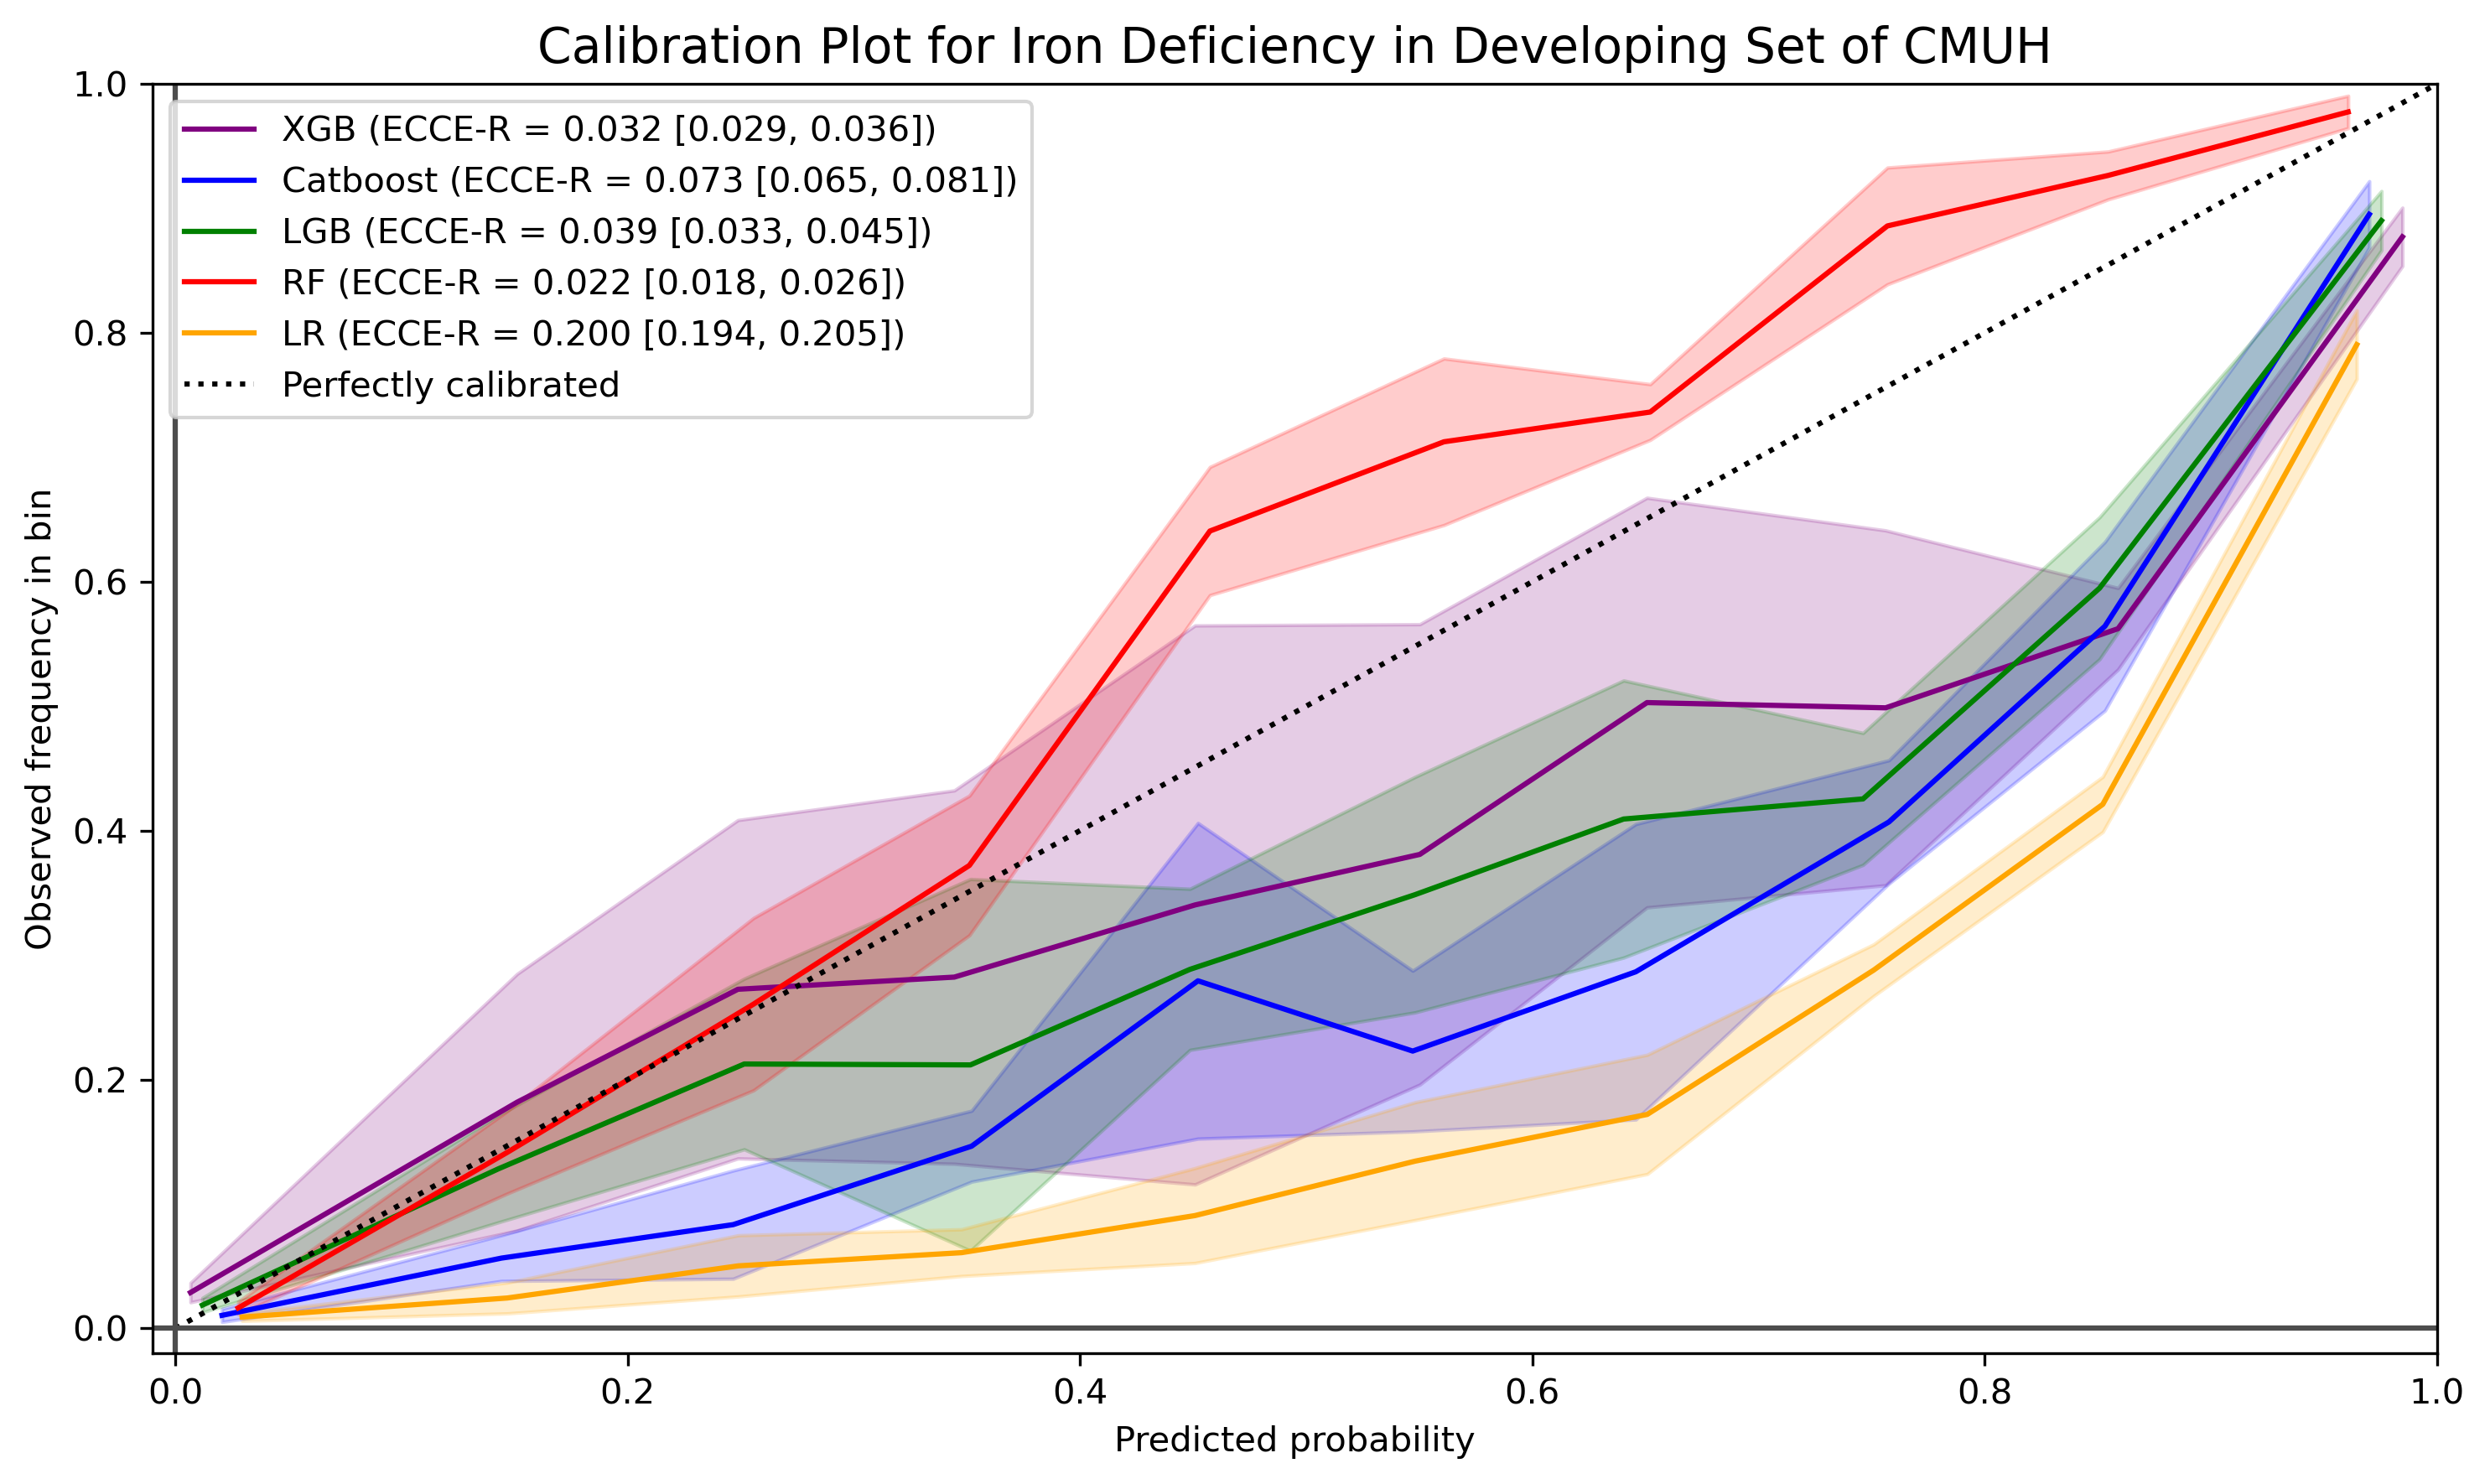

In [10]:
# Define evaluation target and variable combination
target = 'val'
var = 'CBC', 'CPD', 'basic'  # choose the variable combination you want to compare between models

# Initialize dictionaries to store Brier scores and ECCE-R values
brier_scores = {
    'Catboost': [],
    'LGB': [],
    'XGB': [],
    'RF': [],
    'LR': []
}

ecce_r_scores = {
    'Catboost': [], 
    'LGB': [], 
    'XGB': [], 
    'RF': [], 
    'LR': []
}

# Set plotting styles
colors = {'Catboost': 'blue', 'LR': 'orange', 'LGB': 'green', 'RF': 'red', 'XGB': 'purple'}
linestyles = {'Catboost': '-', 'LR': '-', 'LGB': '-', 'RF': '-', 'XGB': '-'}

# Customize global plot appearance
plt.rcParams['axes.facecolor'] = 'white'   # Set plot background color
plt.rcParams['grid.color'] = 'gray'        # Set grid line color
plt.rcParams['grid.alpha'] = 0.2           # Set grid transparency
plt.rcParams['grid.linestyle'] = '-'       # Set grid line style

# Plot calibration curves for each model
plt.figure(figsize=(10, 6), dpi=300)
plt.title(f'Calibration Plot for Iron Deficiency in Developing Set of CMUH', fontsize=14)

for name, model in machine_models:
    all_fold_fractions = []
    all_fold_means = []

    for k in range(1, K + 1):
        # Retrieve predicted probabilities
        prob_pos = results[name, tuple(var)][f'fold_{k}_{target}_auroc']
        
        # Get corresponding true labels
        y_current = y_dict[f'y_{target}_{k}'] if target == 'val' else y_dict[f'y_{target}']
        
        # Compute Brier score
        brier = brier_score_loss(y_current, prob_pos)
        brier_scores[name].append(brier)
        
        # Compute ECCE-R score (calibration error)
        ecce_r = compute_ecce_r(y_current, prob_pos)
        ecce_r_scores[name].append(ecce_r)
        
        # Compute calibration curve
        fraction_of_positives, mean_predicted_value = calibration_curve(y_current, prob_pos, n_bins=10)
        all_fold_fractions.append(fraction_of_positives)
        all_fold_means.append(mean_predicted_value)

    # Aggregate calibration curves across folds
    if all_fold_fractions and all_fold_means:
        avg_fraction_of_positives = np.mean(all_fold_fractions, axis=0)
        avg_mean_predicted_value = np.mean(all_fold_means, axis=0)
        std_err_fraction = sem(all_fold_fractions, axis=0)
        
        # Plot mean calibration curve with 95% CI for ECCE-R
        plt.plot(avg_mean_predicted_value, avg_fraction_of_positives, 
                 label=f'{name} (ECCE-R = {np.mean(ecce_r_scores[name]):.3f} [{np.mean(ecce_r_scores[name]) - 1.96 * np.std(ecce_r_scores[name]) / np.sqrt(K):.3f}, {np.mean(ecce_r_scores[name]) + 1.96 * np.std(ecce_r_scores[name]) / np.sqrt(K):.3f}])',
                 color=colors[name], linestyle=linestyles[name])
        plt.fill_between(avg_mean_predicted_value, 
                         avg_fraction_of_positives - 1.96 * std_err_fraction, 
                         avg_fraction_of_positives + 1.96 * std_err_fraction, 
                         alpha=0.2, color=colors[name])

# Add reference diagonal (perfect calibration line)
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency in bin")
plt.legend(loc='upper left')
plt.xlim(-0.01, 1)
plt.ylim(-0.02, 1)
plt.axhline(y=0, color='#4D4D4D', linewidth=1.5)  # Add x-axis
plt.axvline(x=0, color='#4D4D4D', linewidth=1.5)  # Add y-axis
plt.tight_layout()
plt.show()


In [11]:
# Display average Brier scores with 95% confidence intervals
print("Average Brier Scores with Confidence Intervals:")
for name, scores in brier_scores.items():
    avg_brier = np.mean(scores)
    ci_lower = avg_brier - 1.96 * np.std(scores) / np.sqrt(K)
    ci_upper = avg_brier + 1.96 * np.std(scores) / np.sqrt(K)
    print(f'{name} - Average Brier Score: {avg_brier:.3f} [{ci_lower:.3f}, {ci_upper:.3f}]')

# Display average ECCE-R scores with 95% confidence intervals
print("\nAverage ECCE-R with Confidence Intervals:")
for name, scores in ecce_r_scores.items():
    avg_ecce_r = np.mean(scores)
    ci_lower = avg_ecce_r - 1.96 * np.std(scores) / np.sqrt(K)
    ci_upper = avg_ecce_r + 1.96 * np.std(scores) / np.sqrt(K)
    print(f'{name} - Average ECCE-R: {avg_ecce_r:.4f} [{ci_lower:.4f}, {ci_upper:.4f}]')

Average Brier Scores with Confidence Intervals:
Catboost - Average Brier Score: 0.071 [0.068, 0.075]
LGB - Average Brier Score: 0.064 [0.059, 0.068]
XGB - Average Brier Score: 0.065 [0.061, 0.069]
RF - Average Brier Score: 0.062 [0.057, 0.066]
LR - Average Brier Score: 0.146 [0.141, 0.151]

Average ECCE-R with Confidence Intervals:
Catboost - Average ECCE-R: 0.0734 [0.0654, 0.0814]
LGB - Average ECCE-R: 0.0391 [0.0329, 0.0453]
XGB - Average ECCE-R: 0.0321 [0.0286, 0.0356]
RF - Average ECCE-R: 0.0218 [0.0178, 0.0257]
LR - Average ECCE-R: 0.1995 [0.1938, 0.2052]


### **Single model with different impute method**
  

In [ ]:
# Define the variable set and retrieve corresponding features
var = ['CBC', 'CPD', 'basic']
chosen_col = get_chosen_columns(var)

# List of imputation methods to evaluate
impute_groups = ['zero', 'mean', 'median', 'knn', 'mice']
print(var)

# Assign feature matrix and label vectors for different datasets
x = data_train.loc[:, chosen_col] 
x_test = data_test.loc[:, chosen_col] 
x_ANH = data_ANH.loc[:, chosen_col]
x_WMH = data_WMH.loc[:, chosen_col]

y = data_train['Label']
y_test = data_test['Label']
y_ANH = data_ANH['Label']
y_WMH = data_WMH['Label']

# Initialize an empty dataframe to store results
all_impute_results = pd.DataFrame()

# Dictionary to hold predicted probabilities for each imputation method and fold
results_impute = {method: {} for method in impute_groups}

# Create stratified K-fold cross-validator
skf = StratifiedKFold(n_splits=K, random_state=random_seed, shuffle=True)
impute_names =[]
metrics_columns = ['AUROC', 'AUPRC', 'accuracy', 'F1_score', 'recall', 'specificity', 'precision', 'NPV']
outcome_total = pd.DataFrame({col: pd.Series(dtype='float') for col in metrics_columns})
outcome_test_total = pd.DataFrame({col: pd.Series(dtype='float') for col in metrics_columns})
outcome_ANH_total = pd.DataFrame({col: pd.Series(dtype='float') for col in metrics_columns})
outcome_WMH_total = pd.DataFrame({col: pd.Series(dtype='float') for col in metrics_columns})

# Loop through each imputation method
for impute_method in tqdm(impute_groups):

    # Initialize storage for performance metrics
    fold = 0

    for train_index, val_index in skf.split(x, y):
        fold += 1

        # Split data into training and validation sets
        x_train_cv, x_val = x.iloc[train_index], x.iloc[val_index]
        y_train_cv, y_val = y.iloc[train_index], y.iloc[val_index]

        # Apply sample weighting
        weights_train = np.array([weight_for_0 if label == 0 else weight_for_1 for label in y_train_cv])

        # Perform imputation and scaling on training set
        x_train_imp, m_mean = imputer(x_train_cv, impute_method, train=True)
        x_train_scale, train_scaler = scaling(x_train_imp, None, train=True)

        # Apply same imputation/scaling on validation and test sets
        x_val_imp = imputer(x_val, impute_method, False, m_mean)
        x_val_scale, _ = scaling(x_val_imp, train_scaler, train=False)

        x_test_imp = imputer(x_test, impute_method, False, m_mean)
        x_test_scale, _ = scaling(x_test_imp, train_scaler, train=False)

        x_ANH_imp = imputer(x_ANH, impute_method, False, m_mean)
        x_ANH_scale, _ = scaling(x_ANH_imp, train_scaler, train=False)

        x_WMH_imp = imputer(x_WMH, impute_method, False, m_mean)
        x_WMH_scale, _ = scaling(x_WMH_imp, train_scaler, train=False)

        # Train Random Forest model
        model = RandomForestClassifier(random_state=random_seed)
        model.fit(x_train_scale, y_train_cv, sample_weight=weights_train)

        # Generate predictions
        prob_val = model.predict_proba(x_val_scale)[:, 1]
        prob_test = model.predict_proba(x_test_scale)[:, 1]
        prob_ANH = model.predict_proba(x_ANH_scale)[:, 1]
        prob_WMH = model.predict_proba(x_WMH_scale)[:, 1]

        # Evaluate model performance
        con_matrix_val, outcome, pred = evaluate_model(prob_val, y_val, threshold)
        con_matrix_test, outcome_test, pred_test = evaluate_model(prob_test, y_test, threshold)
        con_matrix_ANH, outcome_ANH, pred_ANH = evaluate_model(prob_ANH, y_ANH, threshold)
        con_matrix_WMH, outcome_WMH, pred_WMH = evaluate_model(prob_WMH, y_WMH, threshold)

        # Accumulate metrics for each fold
        outcome_total = pd.concat([outcome_total, outcome], ignore_index=True)
        outcome_test_total = pd.concat([outcome_test_total, outcome_test], ignore_index=True)
        outcome_ANH_total = pd.concat([outcome_ANH_total, outcome_ANH], ignore_index=True)
        outcome_WMH_total = pd.concat([outcome_WMH_total, outcome_WMH], ignore_index=True)

        # Save predicted probabilities for DeLong test or calibration evaluation
        results_impute[impute_method][f'fold_{fold}_val_auroc'] = prob_val
        results_impute[impute_method][f'fold_{fold}_test_auroc'] = prob_test
        results_impute[impute_method][f'fold_{fold}_ANH_auroc'] = prob_ANH
        results_impute[impute_method][f'fold_{fold}_WMH_auroc'] = prob_WMH

        impute_names.append(impute_method)
# Label and summarize performance for each dataset
outcome_total = outcome_total.assign(impute_name=impute_method).set_index('impute_name')
outcome_test_total = outcome_test_total.assign(impute_name=impute_method).set_index('impute_name')
outcome_ANH_total = outcome_ANH_total.assign(impute_name=impute_method).set_index('impute_name')
outcome_WMH_total = outcome_WMH_total.assign(impute_name=impute_method).set_index('impute_name')

# Print model performance summaries for each cohort
print_model_summary(outcome_total, impute_groups, title='Developing set')
print_model_summary(outcome_test_total, impute_groups, title='Internal validation')
print_model_summary(outcome_ANH_total, impute_groups, title='ANH validation')
print_model_summary(outcome_WMH_total, impute_groups, title='WMH validation')

#### Save results for Delong test

In [ ]:
dump(results_impute, rf'{cache_dir}\impute_result_for_Delong.joblib')

In [ ]:
# Load saved predicted probabilities from previous training runs
results_impute = load(rf'{cache_dir}\impute_result_for_Delong.joblib')

# Define the list of imputation strategies to compare
impute_ways = ['zero', 'mean', 'median', 'mice', 'knn']

# Initialize a nested dictionary to store DeLong test p-values
# Format: p_values[dataset][(impute_1, impute_2)] = list of p-values across folds
p_values = {
    dataset: {
        (impute_1, impute_2): []
        for impute_1, impute_2 in combinations(impute_ways, 2)
    }
    for dataset in ['val', 'test', 'ANH', 'WMH']
}

# Iterate over each fold for pairwise DeLong test comparisons
for k in range(1, K + 1):
    for impute_1, impute_2 in combinations(impute_ways, 2):
        print(f"Running DeLong test between {impute_1} and {impute_2} on fold {k}")
        
        # Retrieve predicted probabilities for each imputation method
        prob1_val = results_impute[impute_1][f'fold_{k}_val_auroc']
        prob2_val = results_impute[impute_2][f'fold_{k}_val_auroc']
        
        prob1_test = results_impute[impute_1][f'fold_{k}_test_auroc']
        prob2_test = results_impute[impute_2][f'fold_{k}_test_auroc']

        prob1_ANH = results_impute[impute_1][f'fold_{k}_ANH_auroc']
        prob2_ANH = results_impute[impute_2][f'fold_{k}_ANH_auroc']
        
        prob1_WMH = results_impute[impute_1][f'fold_{k}_WMH_auroc']
        prob2_WMH = results_impute[impute_2][f'fold_{k}_WMH_auroc']

        # Apply DeLong test (log10 p-value returned), convert back to regular p-value
        p_value_val = 10 ** (delong_roc_test (y_dict[f'y_val_{k}'] == 1, prob1_val, prob2_val))
        p_value_test = 10 ** (delong_roc_test(y_dict ["y_test"] == 1, prob1_test, prob2_test))
        p_value_ANH = 10 ** (delong_roc_test(y_dict["y_ANH"] == 1, prob1_ANH, prob2_ANH))
        p_value_WMH = 10 ** (delong_roc_test(y_dict["y_WMH"] == 1, prob1_WMH, prob2_WMH))

        # Store results into the dictionary
        p_values['val'][(impute_1, impute_2)].append(p_value_val)
        p_values['test'][(impute_1, impute_2)].append(p_value_test)
        p_values['ANH'][(impute_1, impute_2)].append(p_value_ANH)
        p_values['WMH'][(impute_1, impute_2)].append(p_value_WMH)


Running DeLong test between zero and mean on fold 1
Running DeLong test between zero and median on fold 1
Running DeLong test between zero and mice on fold 1
Running DeLong test between zero and knn on fold 1
Running DeLong test between mean and median on fold 1
Running DeLong test between mean and mice on fold 1
Running DeLong test between mean and knn on fold 1
Running DeLong test between median and mice on fold 1
Running DeLong test between median and knn on fold 1
Running DeLong test between mice and knn on fold 1
Running DeLong test between zero and mean on fold 2
Running DeLong test between zero and median on fold 2
Running DeLong test between zero and mice on fold 2
Running DeLong test between zero and knn on fold 2
Running DeLong test between mean and median on fold 2
Running DeLong test between mean and mice on fold 2
Running DeLong test between mean and knn on fold 2
Running DeLong test between median and mice on fold 2
Running DeLong test between median and knn on fold 2
Run

In [ ]:
# In[Calculate average p-values and 95% confidence intervals for each imputation pair]

# Initialize list to store summary statistics across all datasets and method pairs
average_p_values_with_ci = []

# Loop over each dataset (val, test, AN, WMH)
for dataset in p_values.keys():
    for model_pair, p_vals in p_values[dataset].items():  # Ensure value is a dictionary
        mean_p_value = np.mean(p_vals)      # Compute average p-value across folds
        std_p_value = np.std(p_vals)        # Compute standard deviation
        ci = 1.96 * std_p_value             # Approximate 95% confidence interval width (±1.96 * SD)

        # Save results into a dictionary
        average_p_values_with_ci.append({
            'Model 1': model_pair[0],         # First imputation method
            'Model 2': model_pair[1],         # Second imputation method
            'Dataset': dataset,               # Dataset name
            'Mean p-value': mean_p_value,     # Mean of p-values
            'CI Lower': mean_p_value - ci,    # 95% CI lower bound
            'CI Upper': mean_p_value + ci     # 95% CI upper bound
        })

# Convert results to a DataFrame for visualization/export
Delong_imputes = pd.DataFrame(average_p_values_with_ci)

Delong_imputes

,Model 1,Model 2,Dataset,Mean p-value,CI Lower,CI Upper
0,zero,mean,val,0.646388,0.212418,1.080357
1,zero,median,val,0.661821,0.134961,1.188681
2,zero,mice,val,0.410592,-0.284094,1.105278
3,zero,knn,val,0.081068,-0.067950,0.230087
4,mean,median,val,0.432392,0.070621,0.794162
5,mean,mice,val,0.281762,-0.156008,0.719533
6,mean,knn,val,0.053576,-0.035565,0.142718
7,median,mice,val,0.486310,-0.208024,1.180643
8,median,knn,val,0.109348,-0.156860,0.375556
9,mice,knn,val,0.223958,-0.256647,0.704562
